In [393]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

# use the libraries for animations in notebooks
from matplotlib import animation, rc
from IPython.display import HTML

# Cellular automata updating function

As learned from the [*Modeling Complex System*](https://github.com/jlobatop/modeling-complex-systems) course I took, the cellular automata has some characteristics that must be defined before going on. 

* Updates will be done syncronously
* Both types of neighborhoods will be tried when selecting the neighbors: von Nuemann and Moore
* Boundaries willl be absorbing (i.e., walls)

The function <tt>cellUpdate</tt> has the rules coded and it will update the cells.

In [372]:
def cellUpdate(target, neighbors, pD = 0.99, pB = 0.99):
    '''Function to update the cells of the CA 
    
    INPUTS:
       target: target cell value
       neighbors: numpy.ndarray with the corresponding neighbors
       state: state matrix with the initial state of the grain
       pD: probability of the fire of dying out (default = 0.99)
       pB: burning probability of the fire (default = 0.99)
       
    OUTPUTS:
       newState: state of the target cell after update'''
    
    # if the cell is empty
    if target == 0:
        # it will remain empty
        newState = 0
        
    # if the cell is fire
    if target == 1:
        # it may go to empty
        if np.random.rand() < pD:
            newState = 0
        # or it may stay as fire
        else:
            newState = 1
            
    # if the cell is fuel
    if target == 2:
        # neighbor comparison, if there are any 0 or 1
        if np.logical_or(neighbors == 0, neighbors == 1).sum() != 0:
            # it may get in fire
            if np.random.rand() < pB:
                newState = 1
            # or it may stay as fuel 
            else:
                newState = 2
        # if there are no 'fire' nor 'empty', it will remain as fuel
        else:
            newState = 2
            
    return newState

# Cellular automata initialization
The initialization will be done by importing different binary files with arrays of 0 and 1, multiplying it by 2 to have fuel (<tt>2</tt>) and empty (<tt>0</tt>) cells. The function must also ensure that the array is squared (so it can be easily plotted).

In [371]:
def initialization(filename):
    '''Function to update the cells of the CA 
    
    INPUTS:
        filename: name of the file with initialState as squared
                  numpy.ndarray with 0 and 1

    OUTPUTS:
       initialState: corrected file to have only 0 and 2'''
    
    # load the textfile with the desired name
    initialState = np.loadtxt(filename)
    
    # check that the array is squared
    if initialState.shape[0] != initialState.shape[1]:
        # if it is not squared, raise an error
        raise ValueError('Array has not a squared shape')
    # otherwise, return the corrected fuel-empty array
    return 2*initialState

# Cellular automata loop
In this case, the stop condition will be when there are nothing but 0's in the state matrix. So a <tt>while</tt> loop will be used.

In [373]:
# create a list to store the states along time
states = []

# select the type of neighborhood ('moore' or 'vonNeumann')
neighborhoodType = 'vonNeumann'

# load the example 'tubular' file
filename = 'tubular'
states.append(initialization(filename))

# preallocate space for the intermediate state
intState = np.zeros((states[0].shape))

# time counter
t = 0

# loop until there are only zeros in the state
while np.sum(states[t] == 0) != states[t].shape[0]**2:
    
    # loop over all the cells of the array
    # i direction is the tangential direction
    for i in range(states[t].shape[0]):
        
        # j direction is the ratial way
        for j in range(states[t].shape[1]):

            # get te neighbors for the two possible types of neighborhood
            
            # abs((i+1) % states[t].shape[0]) is there for the case where
            # i = states[t].shape[0]-1 which will return error for invalid index 
            
            # More neighborhood type selection
            if neighborhoodType == 'moore':
                # if the index is zero, it will be the center    
                if j == 0:
                    neighbors = np.array([states[t][i-1,j],states[t][i-1,j+1],
                                          states[t][i,j+1],
                                          states[t][abs((i+1) % states[t].shape[0]),j],
                                          states[t][abs((i+1) % states[t].shape[0]),j+1]])
                # if the index is maximum, it will be the rocket wall
                elif j == states[t].shape[1]-1:
                    neighbors = np.array([states[t][i-1,j-1],states[t][i-1,j],
                                          states[t][i,j-1],
                                          states[t][abs((i+1) % states[t].shape[0]),j-1],
                                          states[t][abs((i+1) % states[t].shape[0]),j]])
                # for the 'i' direction the boundaries are connected
                # so all the other cases will follow the same procedure
                else:
                    neighbors = np.array([states[t][i-1,j-1],states[t][i-1,j],states[t][i-1,j+1],
                                          states[t][i,j-1],states[t][i,j+1],
                                          states[t][abs((i+1) % states[t].shape[0]),j-1],
                                          states[t][abs((i+1) % states[t].shape[0]),j],
                                          states[t][abs((i+1) % states[t].shape[0]),j+1]])    

            # von Neumann neighborhood type selection
            else:
                # if the index is zero, it will be the center    
                if j == 0:
                    neighbors = np.array([states[t][i-1,j],
                                          states[t][abs((i+1) % states[t].shape[0]),j],
                                          states[t][i,j+1]])
                # if the index is maximum, it will be the rocket wall
                elif j == states[t].shape[1]-1:
                    neighbors = np.array([states[t][i-1,j],
                                          states[t][abs((i+1) % states[t].shape[0]),j],
                                          states[t][i,j-1]])
                # for the 'i' direction the boundaries are connected (no constraints)
                # so all the other cases will follow the same procedure
                else:
                    neighbors = np.array([states[t][i-1,j],
                                          states[t][abs((i+1) % states[t].shape[0]),j],
                                          states[t][i,j-1],states[t][i,j+1]])
            
            # compute the new value of the target cell
            intState[i,j] = cellUpdate(states[t][i,j],neighbors)
            
    # once the whole array has been updatedd, append it to the list
    states.append(np.copy(intState))
        
    # increase the time counter
    t += 1

In [374]:
def burningState(r, theta, state, iteration, savefigure = False):
    '''Plotting of a state (t) of the grain distribution whereas burning

    INPUTS:
       r: 1D array with the coordinates of the radial position
       theta: 1D array with the coordinates of the tangential position
       state: state matrix with the current state of the grain
       iteration: number of the iteration for saving the figure (when desired)

    OPTIONAL INPUTS:
        savefigure (default=False): flag to save the iteration figure

    OUTPUTS:
       just a plot with the figure'''
    
    # using squared matrix, the dimension will be NxN, so get it from R
    N = len(r)
    
    # create the meshgrid with the 1D arrays
    R, TH = np.meshgrid(r,theta)
    
    # given that the array is created without 2*np.pi, let's complete the 
    # circle to create the contour by setting the same values in the state
    # for 0 and for 2*np.pi (correcting also the other arrays)
    FTH = np.vstack((TH, np.ones(N)*2*np.pi))
    FR = np.vstack((R, np.ones(N)*R[0,:]))
    Fst = np.reshape(np.append(state,state[0,:]),(N+1,N))

    # plot the state with a custom colormap
    fig = plt.figure(1, figsize = (15,15), dpi = 50)
    ax = plt.subplot(111, projection = 'polar')
    ax.contourf(FTH, FR, Fst, 2, cmap = grainStates, norm = norm)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    
    # save the figure if it explicitilly said
    if savefigure:
        plt.savefig('state%i.png' %iteration, bbox_inches='tight')

In [375]:
N = states[0].shape[0]

In [376]:
levels = [0, 0.5, 1.5, 2.5]
colors = ['white', 'red', [0.4,0.4,0.4]]
grainStates, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

In [377]:
# linspace for the radial direction
r = np.linspace(0,1,N)

# tangential direction (avoiding computation of the 0 = 2*np.pi)
theta = np.linspace(0,2*np.pi*(N-1)/N,N)

/home/jlobatop/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

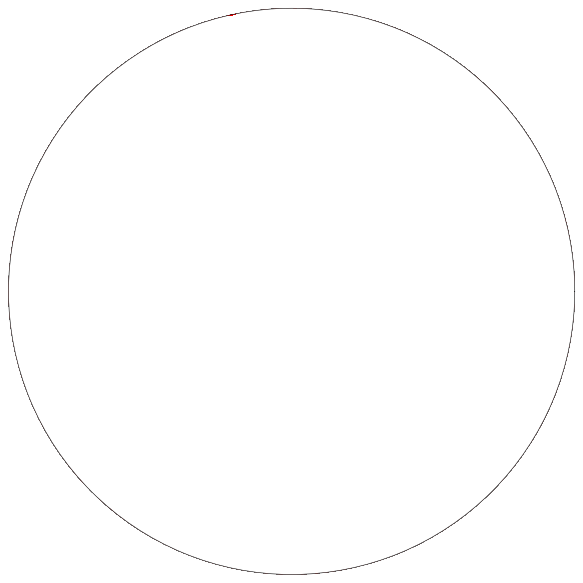

In [396]:
[burningState(r,theta,states[i],i,savefigure=True) for i in range(len(states))];

os.system
convert -delay 2  $(ls -v state*.png) tubular.gif

# Normalize thrust computation
To have the thrust profile curve, this will be computed with:
$$
T = I_{sp} g_0 \dot{m}
$$
st roberts law

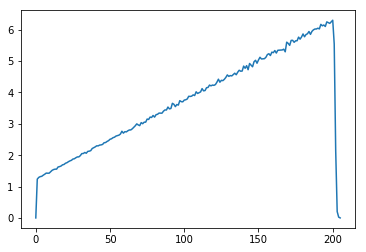

In [423]:
# Ttilda = [(states[t]==1).sum() for t in range(len(states))]
Ttilda = [(2*np.pi*r/states[t].shape[0]*states[t])[states[t]==1].sum() for t in range(len(states))]
plt.plot(Ttilda)
